<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/5_Dinamic_model_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

# Feature engineering and scaling

In [4]:
data = mf.feature_engineering(data)
data = mf.feature_scaling(data)
data = pd.get_dummies(data)

# Dinamic model

In [5]:
init_splits = 4
incoming_splits = 2
tot_splits = 10

In [6]:
def get_split_id(data, init_splits, incoming_splits, tot_splits):
  id = {} # dizionario con (split : id_righe)
  id_fraud = {} # dizionario con (split: id righe transazioni fraudolente)
  for i in range(tot_splits):
    id[i] = data[(data['TransactionDT']>=(i/tot_splits)) & (data['TransactionDT']<((i + 1)/tot_splits))].index.tolist()
    id_fraud[i] = data[(data['TransactionDT']>=(i/tot_splits)) & (data['TransactionDT']<((i + 1)/tot_splits)) & (data['isFraud'] == 1)].index.tolist()
    
  return id, id_fraud

In [7]:
class model:
  name = 'XGBoost'

  def __init__(self, t):
    self.t = t
    self.f1 = 0
    self.precision = 0
    self.recall = 0
    self.roc = 0
    self.proba = []
    self.prediction = []
    self.train_id = [] # lista con le righe su cui il modello si è allenato
    self.val_id = [] # lista con le righe su cui il modello viene validato
    # model_dict[t] = self # dizionario che contiene (tempo: modello t-esimo)
    return

  def __str__(self):
    return f"{self.name}, at time {self.t}, with f1 score of {self.f1}"

  def init_xgb(self, estimators = 1000, depth = 6): # inizializza xgb
    import xgboost 
    from xgboost import XGBClassifier
    self.xgb = XGBClassifier(n_estimators = estimators, max_depth = depth, 
                      objective='binary:logistic', learning_rate = 0.5, 
                      tree_method='gpu_hist')
    return f'{self.name} at time {self.t}, has been initialised.'
  
  def train_xgb(self, X_train, y_train): # traina il modello
    self.xgb.fit(X_train.to_numpy(), y_train.to_numpy())
    return f'{self.name} is now trained!'

  def get_set(self, data, id_list): # restituisce il subset dati gli id delle righe
    # id_list: è l'elemento id[t] 
    subset = data.iloc[id_list,:]
    return subset

  def proba_predictions(self, X_val): # restituisce le probabilità
    if not self.xgb:
      return f'{self.name} is not declared. You need to use init_xgb'
    self.proba = self.xgb.predict_proba(X_val, validate_features = False)
    return self.proba

  def aggregate(self, soglia = 0.05): # resituisce la classe
    # if not self.proba:
    #   return f'self.proba is empty. Before aggregate, you need to use proba_predictions'
    self.prediction = []
    for proba in self.proba[:,1]:
      if proba > soglia:
        self.prediction.append(1)
      else:
        self.prediction.append(0)
    return f'Classification has been councluded!'

  def performance(self, y_val, soglia = 0.05):
    from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
    
    print('\n')
    print('Confusion matrix of model ', self.name,' of time ', self.t)
    mf.plot_cm(y_val, self.prediction, 'Blues', p = soglia, dynamic = True)
    
    self.score = f1_score(y_val, self.prediction).round(2)
    self.roc = roc_auc_score(y_val, self.prediction).round(2)
    self.precision = precision_score(y_val, self.prediction,  average='binary').round(2)
    self.recall = recall_score(y_val, self.prediction, average='binary').round(2)

    print('\n')
    print('Model f1 score: ', self.score)
    print('Model roc auc score: ', self.roc)
    print('Model recall: ', self.recall)
    print('Model precision: ', self.precision)
    print('\n')
    return 

In [8]:
class ensemble(model): # child class di model
  name = 'Ensemble'
  # come model_dict passare il dizionario in cui si salvano gli ensemble

  #override 
  def proba_predictions(self, model_dict, X_val):
    prob = []
    for t in model_dict:
      prob.append(model_dict[t].proba_predictions(X_val)[:,1])
    self.proba = np.mean(prob, axis = 0)
    return f'Proba acquired.'
  
  #override
  def aggregate(self, soglia = 0.05):
    for proba in self.proba:
      if proba > soglia:
        self.prediction.append(1)
      else:
        self.prediction.append(0)
    return f'Classification has been councluded!'

In [9]:
def get_t_id(data, id, t, init_splits, incoming_splits):
  id_list = [] # lista che conterrà le righe da usare al tempo t
  if t == 0:
    start = 0
    end = init_splits
  else:
    start = incoming_splits * (t - 1) + init_splits
    end = start + incoming_splits

  # selected_id = id[t][start:end]
  for n in range(start,end):
    id_list += id[n]
  # for n in selected_id:
  #   id_list += selected_id[n]
  return id_list

In [10]:
def train_model(sel_model, data, id_t):
  # Inizializzazione modello
  sel_model.init_xgb() # inizializzo xgb

  # Train test split
  subset = sel_model.get_set(data, id_t) # seleziono il subset su cui il modello si allenerà
  # print(subset)
  X_train, X_val, y_train, y_val = mf.split(subset, test_size = 0.2) # train test split
  sel_model.train_id = X_train.index.tolist() # salvo gli id del training set 
  sel_model.val_id = X_val.index.tolist() # salvo gli id del test set

  # Training del modello
  soglia = 0.05
  sel_model.train_xgb(X_train, y_train) # train di xgb 

  return f'Training ended. \n'

In [11]:
def test_model(sel_model, last_model, data, soglia):
  id_list = last_model.val_id # seleziono le righe su cui va validato l'ultimo modello
  subset = last_model.get_set(data, id_list) # seleziono il set su cui valido i dati
  y_val = subset['isFraud']
  # print(y_val)
  X_val = subset.drop(columns=['isFraud'], axis = 1)
  sel_model.proba_predictions(X_val) # predict_proba
  sel_model.aggregate(soglia = soglia) # predict

  sel_model.performance(y_val, soglia = soglia) # valuta le performance del modello
  return 

In [12]:
def test_ensemble(ens, model_dict, t, data, id_t):
  subset = model_dict[t].get_set(data, id_t) # seleziono il set su cui valido i dati
  y_val = subset['isFraud']
  X_val = subset.drop(columns=['isFraud'], axis = 1)
  ens.proba_predictions(model_dict, X_val) # predict_proba dell'ensemble
  ens.aggregate() # predict dell'ensemble
  ens.performance(y_val) # valuto le performance
  return f'Ensemble testing ended. \n'

In [13]:
def dinamic_model(data, id, id_fraud, init_splits, incoming_splits, tot_splits):
  tmax = np.ceil((tot_splits) / incoming_splits)
  model_dict = {}
  ensemble_dict = {}
  soglia = 0.05

  for t in range(int(tmax - 1)):
    print('Time ', t)
    id_t = get_t_id(data, id, t, init_splits, incoming_splits) # ottengo gli id delle righe da usare al tempo t-esimo
    model_dict[t] = model(t) # inizializzo il modello t-esimo 
    train_model(model_dict[t], data, id_t) # train e test del modello t-esimo
    if t > 0:
      ensemble_dict[t] = ensemble(t) # inizializzo l'ensemble t-esimo
      test_ensemble(ensemble_dict[t], model_dict, t, data, id_t) # testo l'ensemble
    for i in model_dict:
      test_model(model_dict[i], model_dict[t], data, soglia)

  return model_dict, ensemble_dict

Time  0
        isFraud  TransactionDT  ...  screen_h_990  screen_h_992
0           0.0   0.000000e+00  ...             0             0
1           0.0   6.359409e-08  ...             0             0
2           0.0   4.387992e-06  ...             0             0
3           0.0   6.295815e-06  ...             0             0
4           0.0   6.740974e-06  ...             0             0
...         ...            ...  ...           ...           ...
263896      0.0   3.999944e-01  ...             0             0
263897      0.0   3.999951e-01  ...             0             0
263898      0.0   3.999952e-01  ...             0             0
263899      0.0   3.999984e-01  ...             0             0
263900      0.0   3.999991e-01  ...             0             0

[263901 rows x 1104 columns]
235063    0.0
182231    0.0
169250    0.0
191710    0.0
20802     0.0
         ... 
248033    0.0
54984     0.0
255676    0.0
241703    0.0
102953    0.0
Name: isFraud, Length: 52781, dtype: flo

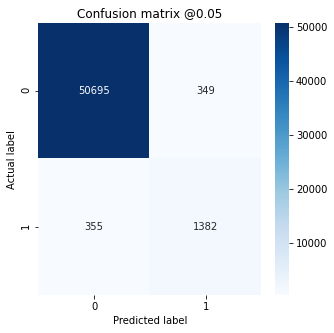



Confusion matrix of model  XGBoost  of time  0


Model f1 score:  0.8
Model roc auc score:  0.89
Model recall:  0.8
Model precision:  0.8


Time  1
        isFraud  TransactionDT  ...  screen_h_990  screen_h_992
263901      0.0       0.400001  ...             0             0
263902      0.0       0.400002  ...             0             0
263903      0.0       0.400002  ...             0             0
263904      0.0       0.400002  ...             0             0
263905      0.0       0.400003  ...             0             0
...         ...            ...  ...           ...           ...
380804      0.0       0.599984  ...             0             0
380805      0.0       0.599986  ...             0             0
380806      0.0       0.599988  ...             0             0
380807      0.0       0.599994  ...             0             0
380808      0.0       0.599999  ...             0             0

[116908 rows x 1104 columns]


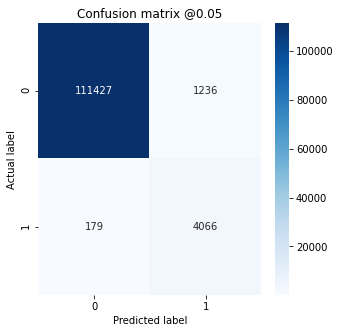



Confusion matrix of model  Ensemble  of time  1


Model f1 score:  0.85
Model roc auc score:  0.97
Model recall:  0.96
Model precision:  0.77


307339    0.0
275455    0.0
323888    0.0
327143    0.0
366092    0.0
         ... 
341546    0.0
288810    0.0
374400    0.0
304394    0.0
346014    0.0
Name: isFraud, Length: 23382, dtype: float64


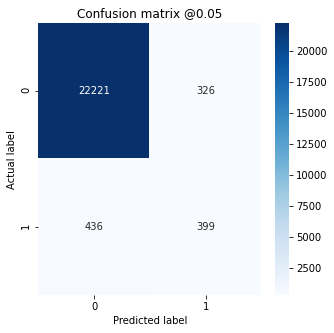



Confusion matrix of model  XGBoost  of time  0


Model f1 score:  0.51
Model roc auc score:  0.73
Model recall:  0.48
Model precision:  0.55


307339    0.0
275455    0.0
323888    0.0
327143    0.0
366092    0.0
         ... 
341546    0.0
288810    0.0
374400    0.0
304394    0.0
346014    0.0
Name: isFraud, Length: 23382, dtype: float64


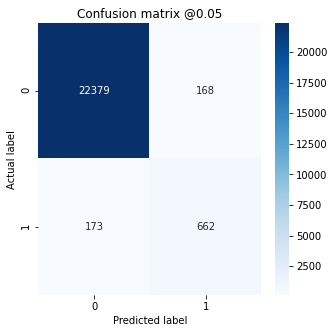



Confusion matrix of model  XGBoost  of time  1


Model f1 score:  0.8
Model roc auc score:  0.89
Model recall:  0.79
Model precision:  0.8


Time  2
        isFraud  TransactionDT  ...  screen_h_990  screen_h_992
380809      0.0       0.600002  ...             0             0
380810      0.0       0.600008  ...             0             0
380811      1.0       0.600008  ...             0             0
380812      0.0       0.600008  ...             0             0
380813      0.0       0.600012  ...             0             0
...         ...            ...  ...           ...           ...
485892      0.0       0.799996  ...             0             0
485893      0.0       0.799997  ...             0             0
485894      0.0       0.799998  ...             0             0
485895      0.0       0.799998  ...             0             0
485896      0.0       0.799999  ...             0             0

[105088 rows x 1104 columns]


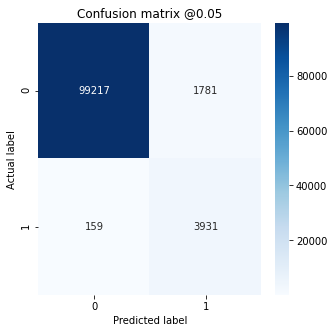



Confusion matrix of model  Ensemble  of time  2


Model f1 score:  0.8
Model roc auc score:  0.97
Model recall:  0.96
Model precision:  0.69


399263    0.0
412240    1.0
457313    0.0
415546    0.0
422859    0.0
         ... 
479744    0.0
389448    0.0
425027    0.0
403088    0.0
398582    0.0
Name: isFraud, Length: 21018, dtype: float64


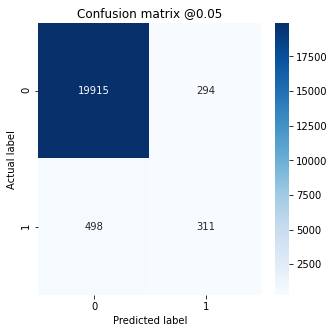



Confusion matrix of model  XGBoost  of time  0


Model f1 score:  0.44
Model roc auc score:  0.68
Model recall:  0.38
Model precision:  0.51


399263    0.0
412240    1.0
457313    0.0
415546    0.0
422859    0.0
         ... 
479744    0.0
389448    0.0
425027    0.0
403088    0.0
398582    0.0
Name: isFraud, Length: 21018, dtype: float64


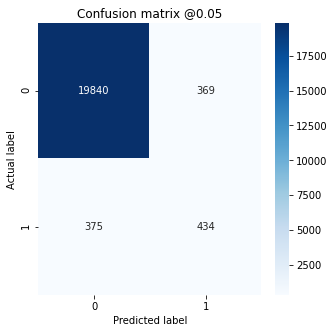



Confusion matrix of model  XGBoost  of time  1


Model f1 score:  0.54
Model roc auc score:  0.76
Model recall:  0.54
Model precision:  0.54


399263    0.0
412240    1.0
457313    0.0
415546    0.0
422859    0.0
         ... 
479744    0.0
389448    0.0
425027    0.0
403088    0.0
398582    0.0
Name: isFraud, Length: 21018, dtype: float64


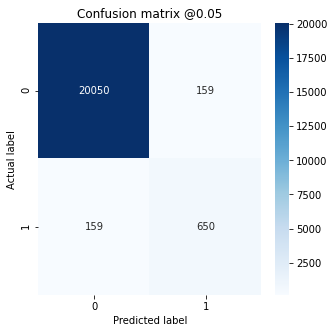



Confusion matrix of model  XGBoost  of time  2


Model f1 score:  0.8
Model roc auc score:  0.9
Model recall:  0.8
Model precision:  0.8


Time  3
        isFraud  TransactionDT  ...  screen_h_990  screen_h_992
485897      0.0       0.800002  ...             0             0
485898      0.0       0.800003  ...             0             0
485899      0.0       0.800003  ...             0             0
485900      0.0       0.800007  ...             0             0
485901      0.0       0.800007  ...             0             0
...         ...            ...  ...           ...           ...
590527      0.0       0.999994  ...             0             0
590528      0.0       0.999995  ...             0             0
590529      0.0       0.999995  ...             0             0
590530      0.0       0.999997  ...             0             0
590531      0.0       0.999997  ...             0             0

[104635 rows x 1104 columns]


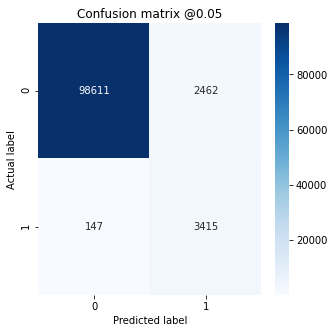



Confusion matrix of model  Ensemble  of time  3


Model f1 score:  0.72
Model roc auc score:  0.97
Model recall:  0.96
Model precision:  0.58


562037    0.0
568190    0.0
492198    0.0
533142    0.0
495458    0.0
         ... 
580149    0.0
516968    0.0
581063    0.0
544267    0.0
487416    0.0
Name: isFraud, Length: 20927, dtype: float64


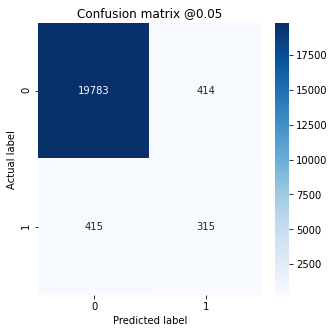



Confusion matrix of model  XGBoost  of time  0


Model f1 score:  0.43
Model roc auc score:  0.71
Model recall:  0.43
Model precision:  0.43


562037    0.0
568190    0.0
492198    0.0
533142    0.0
495458    0.0
         ... 
580149    0.0
516968    0.0
581063    0.0
544267    0.0
487416    0.0
Name: isFraud, Length: 20927, dtype: float64


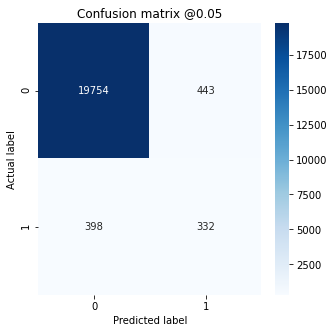



Confusion matrix of model  XGBoost  of time  1


Model f1 score:  0.44
Model roc auc score:  0.72
Model recall:  0.45
Model precision:  0.43


562037    0.0
568190    0.0
492198    0.0
533142    0.0
495458    0.0
         ... 
580149    0.0
516968    0.0
581063    0.0
544267    0.0
487416    0.0
Name: isFraud, Length: 20927, dtype: float64


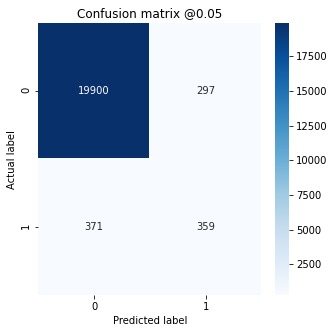



Confusion matrix of model  XGBoost  of time  2


Model f1 score:  0.52
Model roc auc score:  0.74
Model recall:  0.49
Model precision:  0.55


562037    0.0
568190    0.0
492198    0.0
533142    0.0
495458    0.0
         ... 
580149    0.0
516968    0.0
581063    0.0
544267    0.0
487416    0.0
Name: isFraud, Length: 20927, dtype: float64


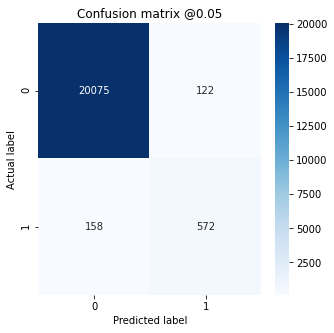



Confusion matrix of model  XGBoost  of time  3


Model f1 score:  0.8
Model roc auc score:  0.89
Model recall:  0.78
Model precision:  0.82




In [14]:
id, id_fraud = get_split_id(data, init_splits, incoming_splits, tot_splits) # splitta le righe in base agli split dichiarati
model_dict, ensemble_dict = dinamic_model(data, id, id_fraud, init_splits, incoming_splits, tot_splits)